In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
from pathlib import Path
import urllib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
! pip install seaborn --upgrade
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Requirement already up-to-date: seaborn in c:\programdata\anaconda3\envs\practicum\lib\site-packages (0.11.1)


<h1 align="center">Оптимизация золотодобывающего производства</h1>

## Краткое описание проекта

Компания «Цифра» разрабатывает решения для эффективной работы промышленных предприятий. **Целью** данного проекта является подготовка прототипа модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. В рамках проекта потребуется решить следующие *задачи*:

1. Получить данные;
2. Подготовить данные для анализа и обучения на них;
3. Провести исследовательский анализ данных;
4. Построить и обучить модель.

## Описание технологического процесса, признаков, метрик<a id="in"></a>

### Схема технологического процесса получения золота из руды и его описание<a id="proc"></a>

![Технологический процесс](https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg)

Опишем каждую стадию:
1. **Флотация**. Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов. На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. **Очистка**. Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных<a id="des_data"></a>

**Технологический процесс:**
- *Rougher feed* — исходное сырье;
- *Rougher additions* (или reagent *additions*) — флотационные реагенты:
    - *Xanthate* — ксантогенат (промотер, или активатор флотации);
    - *Sulphate* — сульфат (на данном производстве сульфид натрия);
    - *Depressant* — депрессант (силикат натрия).
- *Rougher process* (англ. «грубый процесс») — флотация;
- *Rougher tails* — отвальные хвосты;
- *Float banks* — флотационная установка;
- *Cleaner process* — очистка;
- *Rougher Au* — черновой концентрат золота;
- *Final Au* — финальный концентрат золота.

**Параметры этапов:**
- *air amount* — объём воздуха;
- *fluid levels* — уровень жидкости;
- *feed size* — размер гранул сырья;
- *feed rate* — скорость подачи.


### Наименование признаков<a id="feat"></a>

Наименование признаков должно быть такое: `[этап].[тип_параметра].[название_параметра]`.

Пример: `rougher.input.feed_ag`.

Возможные значения для блока `[этап]`:
- *rougher* — флотация;
- *primary_cleaner* — первичная очистка;
- *secondary_cleaner* — вторичная очистка;
- *final* — финальные характеристики.

Возможные значения для блока `[тип_параметра]`:
- *input* — параметры сырья;
- *output* — параметры продукта;
- *state* — параметры, характеризующие текущее состояние этапа;
- *calculation* — расчётные характеристики.


### Расчёт эффективности<a id="rec"></a>

Эффективность обогащения рассчитывается по формуле:

$$Recovery = \frac{C\times(F-T)}{F\times(C-T)}\times100\%$$

где:
- *C* - доля золота в концентрате после флотации/очистки;
- *F* — доля золота в сырье/концентрате до флотации/очистки;
- *T* — доля золота в отвальных хвостах после флотации/очистки

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах.

### Метрика качества<a id="metric"></a>

Для оценки используем метрику качества — **sMAPE** (англ. *Symmetric Mean Absolute Percentage Error*, «симметричное среднее абсолютное процентное отклонение»). Она одинаково учитывает масштаб и целевого признака, и предсказания. Метрика **sMAPE** вычисляется так:

$$sMAPE = \frac{1}{N} \sum_{i=1}^N \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2}\times100\%$$

где:
- ${y_i}$ - значение целевого признака для объекта с порядковым номером *i* в выборке, на которой измеряется качество;
- $\hat{y_i}$ - значение предсказания для объекта с порядковым номером *i* в выборке, на которой измеряется качество;
- $N$ - количество объектов в выборке.

Нужно спрогнозировать эффективность обогащения чернового концентрата `rougher.output.recovery` и эффективность обогащения финального концентрата `final.output.recovery`. Итоговая метрика складывается при этом из двух величин:

$$sMAPE_{result} = 25\% \times sMAPE_{rougher} + 75\% \times sMAPE_{final}$$

## Получение данных<a id="start"></a>

Подготовим функцию для проверки наличия файлов и их загрузки при необходимости.

In [2]:
Path('/datasets').mkdir(parents=True,exist_ok=True)
def get_file(file_name, url):
    
    if not os.path.exists(file_name):
        print(file_name,'не найден. Файл будет загружен из сети')
        _ = urllib.request.urlretrieve(url, file_name)

urls = {
    'gold_recovery_train': ('/datasets/gold_recovery_train.csv', 'https://.../gold_recovery_train.csv'),
    'gold_recovery_test': ('/datasets/gold_recovery_test.csv', 'https://.../gold_recovery_test.csv'),
    'gold_recovery_full': ('/datasets/gold_recovery_full.csv', 'https://.../gold_recovery_full.csv')
}

[get_file(*urls[k]) for k in urls]

[None]

Сохраним предоставленные датасеты в соответствующих переменных и рассмотрим основную информацию о них.

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
test = pd.read_csv('/datasets/gold_recovery_test.csv')
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [7]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

### Вывод

Данные уже разделены на обучающую и тестовую выборки. В данных присутствуют пропуски, которые предстоит обработать. Также в тестовой выборке отсутствует ряд столбцов, которые есть в обучающей и полной выборках. Заметим, что это признаки с типом параметра `output`, то есть параметры продукта после каждой стадии обработки. Мы не сможем использовать их для обучения модели, так как не знаем их заранее. Поэтому из обучающей выборки их придется удалить на этапе подготовки данных. При этом в тестовую выборку нужно добавить целевые признаки для проверки качества модели. Дополнительно на этапе подготовки проверим, действительно ли обучающая и тестовая выборки взяты из исходных данных, и правильность расчета эффективности.

## Подготовка данных<a id="prep"></a>

### Преобразование дат<a id="date"></a>

Преобразуем формат дат методом `pd.to_datetime()` во всех таблицах.

In [9]:
def to_datetime(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S')

In [10]:
to_datetime(train, 'date')
to_datetime(test, 'date')
to_datetime(full, 'date')
print(train['date'].dtype)
print(test['date'].dtype)
print(full['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


Преобразование прошло успешно. Сделаем столбец с датой индексом для каждого датафрейма.

### Проверка исходных данных<a id="orig"></a>

Проверим, взяты ли обучающая и тестовая выборки из `full`. Для этого объединим их методом `concat()`, а объединенную таблицу присоедим к `full` методом `merge()` по дате. Затем сравним размер полученной после применения `merge()` таблицы с исходной.

In [11]:
data_c = pd.concat([train] + [test])
data_merge = full.merge(data_c, on='date', how='outer')
print('Размер исходных данных:', full.shape)
print('Размер исходных данных после присоединения объединенной выборки:', data_merge.shape)

Размер исходных данных: (22716, 87)
Размер исходных данных после присоединения объединенной выборки: (22716, 173)


Количество строк не изменилось, значит даты во всех таблицах совпадают. Можно сказать о том, что данные в обучающую и тестовую выборки взяты из исходных данных.

### Проверка расчета эффективности<a id="rec"></a>

Проверим расчет эффективности для этапа флотации на обучающей выборке. Сначала сохраним промежуточный датасет с удаленными пропысками в перменной `data_0`. Затем рассчитаем эффективность по формуле из раздела 1 и сохраним полученные значения в столбце *'rec'*.

In [12]:
data_0 = train.dropna()

In [13]:
def recovery(row):
    c = row['rougher.output.concentrate_au'] 
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    recovery = 100 * c * (f - t) / (f * (c - t))
    return recovery

In [14]:
data_0['rec'] = data_0.apply(recovery, axis=1)

Найдем среднее квадратичное отклонение между рассчитанными значениями и указанными в обучающей выборке.

In [15]:
mean_squared_error(data_0['rec'], data_0['rougher.output.recovery'])

2.503160122454227e-28

*MAE* очень мала, поэтому можно говорить о верности значений эффективности, указанных в данных.

### Корректировка выборок<a id="format"></a>

Нам необходимо добавить целевые признаки (`rougher.output.recovery` и `final.output.recovery`) в тестовую выборку, а из обучающей удалить признаки, которых нет в тестовой (с типом параметра `output`).

Размер тестовой выборки до добавления признаков.

In [16]:
test.shape

(5856, 53)

Добавим целевые признаки в тестовую выборку из исходных данных методом `merge()`. Затем проверим результат.

In [17]:
test = pd.merge(test, full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')
test.shape

(5856, 55)

In [18]:
test.head(1)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583


Удалим из `train` столбцы с признаками, которых нет в `test`. Но сначала ознакомимся с ними и проверим выводы, сделанные на этапе получения данных.

In [19]:
col = list(set(train.columns) - set(test.columns))
col

['primary_cleaner.output.tail_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'secondary_cleaner.output.tail_pb',
 'final.output.concentrate_sol',
 'final.output.tail_sol',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.tail_pb',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_sol',
 'final.output.concentrate_pb',
 'final.output.tail_au',
 'final.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.tail_ag',
 'rougher.output.concentrate_ag',
 'rougher.output.tail_sol',
 'final.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'rougher.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'secondary_cleaner.output.tail_au',
 'secon

Видно, что кроме параметров продукта на разных этапах, в тестовой выборке нет рассчитываемых параметров, обозначенных *calculation*, что логично, ведь их заранее мы тоже знать не можем. Выполним удаление столбцов.

In [20]:
train = train.drop(col, axis=1)
train.shape

(16860, 55)

В тренировочной выборке остались нужные нам 55 столбцов.

### Обработка пропусков<a id="fillna"></a>

Удалим пропуски из выборок (попытка их заменить может ухудшить качество моделей).

In [21]:
train = train.set_index('date')
test = test.set_index('date')
full = full.set_index('date')

In [22]:
full = full.dropna()
train = train.dropna()
test = test.dropna()

### Вывод

В результате обработки данных:
- Убедились в том, что обучающая и тестовая выборки взяты из исходных данных, а расчет эффективности выполнен верно (проверили для этапа флотации). 
- Добавили в тестовую выборку целевые признаки, а из обучающей выборки убрали признаки, которые рассчитываются во время процесса обработки и не известны до его начала (из-за этого не могут быть использованы для обучения модели). 
- Избавились от пропусков, удалив их.

## Исследовательский анализ данных<a id="analysis"></a>

### Изменение концентрации металлов<a id="con"></a>

Изучим изменение концентрации металлов (*Au* - золото, *Ag* - серебро, *Pb* - свинец) наразличных этапах очистки. Используем для этого исходные данные.

Построим гистограммы концентраций в сырье, после флотации, первичной очистки и в финальном концентрате для каждого металла.

In [23]:
au = full[['rougher.input.feed_au', 'rougher.output.concentrate_au',
          'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
au.columns = ['сырье', 'флотация', 'первичная очистка', 'конечный резултат']

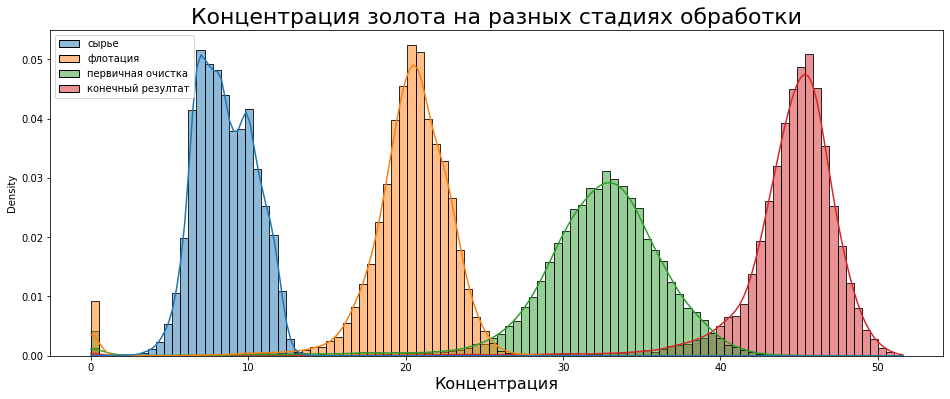

In [24]:
plt.figure(figsize=(16, 6))
sns.histplot(au, bins=100, stat='density', kde=True, label=True)
plt.title('Концентрация золота на разных стадиях обработки', fontsize = 22)
plt.xlabel('Концентрация', fontsize = 16)
plt.show()

Концентрация золота повышается от этапу, при этом делает это достаточно равномерно.

In [25]:
ag = full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
          'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
ag.columns = ['сырье', 'флотация', 'первичная очистка', 'конечный резултат']

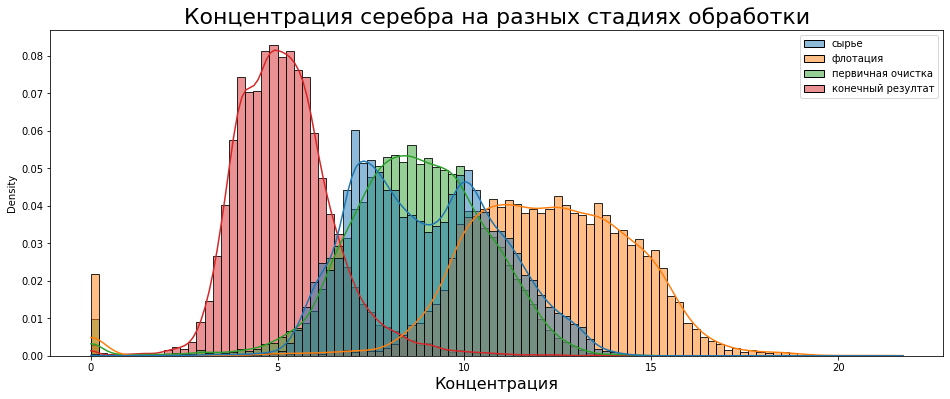

In [26]:
plt.figure(figsize=(16, 6))
sns.histplot(ag, bins=100, stat='density', kde=True, label=True)
plt.title('Концентрация серебра на разных стадиях обработки', fontsize = 22)
plt.xlabel('Концентрация', fontsize = 16)
plt.show()

Концентрация серебра повышается после этапа флотации, а затем снижается, достигая минимальных значений в финальном концентрате.

In [27]:
pb = full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
          'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
pb.columns = ['сырье', 'флотация', 'первичная очистка', 'конечный резултат']

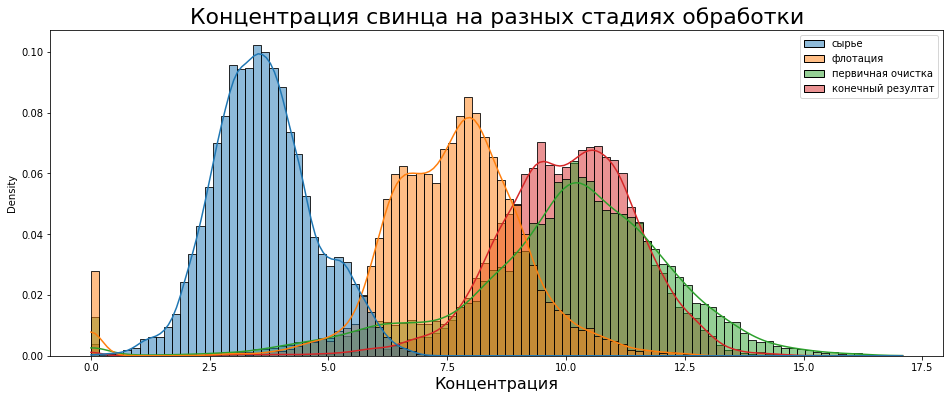

In [28]:
plt.figure(figsize=(16, 6))
sns.histplot(pb, bins=100, stat='density', kde=True, label=True)
plt.title('Концентрация свинца на разных стадиях обработки', fontsize = 22)
plt.xlabel('Концентрация', fontsize = 16)
plt.show()

Концентрация свинца повышается в процессе обработки, достигая максимальных значений после первичной очистки. После нее концентрация меняется слабо.

Также для всех металлов характерны значения концентраций, близкие к нулю, на всех этапах обработки. Их мы рассмотрим далее в этом разделе.

### Распределение размеров гранул сырья<a id="feed"></a>

Сравним распределение размеров гранул сырья на обучающей и тестовой выборках. Значения размера гранул находятся в столбце *'rougher.input.feed_size'*.

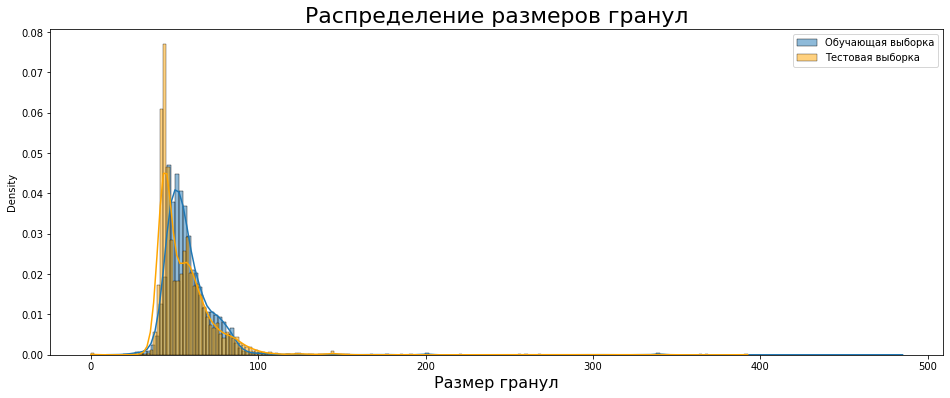

In [29]:
plt.figure(figsize=(16, 6))
sns.histplot(train['rougher.input.feed_size'], stat='density', label='Обучающая выборка', bins=200, kde=True)
sns.histplot(test['rougher.input.feed_size'], stat='density', label='Тестовая выборка', bins=200, kde=True, color='orange')
plt.title('Распределение размеров гранул', fontsize = 22)
plt.xlabel('Размер гранул', fontsize = 16)
plt.legend()
plt.show()

Распределения не идентичны, но похожи. При обучении модели можно попробовать исключить эти признаки и посмотреть, как при этом изменится качество. 

### Суммарная концентрация металлов<a id="sum"></a>

Изучим суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Соберем суммарные концентрации металлов на разных этапах в один датафрейм и постром гистограммы.

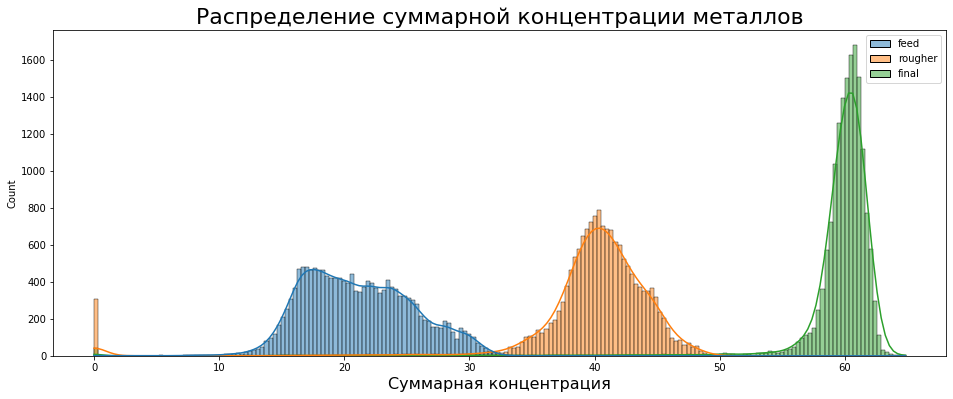

In [30]:
df = pd.DataFrame()
df['feed'] = full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] + full['rougher.input.feed_au']
df['rougher'] = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_au']
df['final'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] + full['final.output.concentrate_au']
plt.figure(figsize=(16, 6))
sns.histplot(df, bins=200, kde=True)
plt.title('Распределение суммарной концентрации металлов', fontsize = 22)
plt.xlabel('Суммарная концентрация', fontsize = 16)
plt.show()

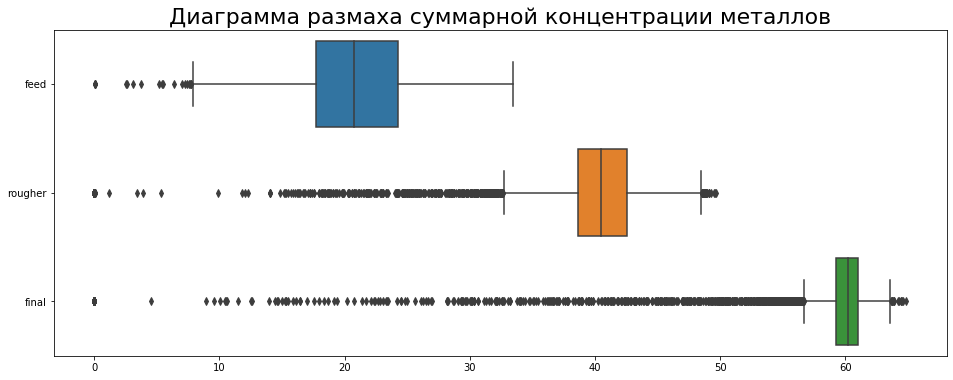

In [31]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df, orient='h')
plt.title('Диаграмма размаха суммарной концентрации металлов', fontsize = 22)
plt.show()

В районе нуля есть значения на всех этапах. Имеет смысл удалить строки, суммарная конценрация металлов в сырье и черновом концентрате близка к 0. Поищем такие строки, а потом удалим их из обучающей и тестовой выборки.

In [32]:
df.describe()

,feed,rougher,final
count,16094.000000,16094.000000,16094.000000
mean,21.138892,39.690192,59.496007
std,4.333338,6.641670,4.829479
min,0.030000,0.000000,0.000000
25%,17.693828,38.646429,59.303525
50%,20.723608,40.515743,60.256525
75%,24.231711,42.592028,61.050368
max,33.498784,49.700943,64.856303


Коцентрации в сырье отличны от нуля, но при этом есть очень малые значения.

In [33]:
wrong_train = []
wrong_test = []
for i in df.query('feed < 1').index:
    if i in train.index:
        wrong_train.append(i)
    else:
        wrong_test.append(i)
print('Всего строк с малой концентрацией металлов в сырье:', len(df.query('feed < 1').index))
print('Количество строк с малой концентрацией в обучающей выборке:', len(wrong_train))
print('Количество строк с малой концентрацией в тестовой выборке:', len(wrong_test))

Всего строк с малой концентрацией металлов в сырье: 5
Количество строк с малой концентрацией в обучающей выборке: 5
Количество строк с малой концентрацией в тестовой выборке: 0


Добавим индексы строк с малыми концетрациями в черновом концентрате.

In [34]:
for i in df.query('rougher < 1').index:
    if i in train.index:
        wrong_train.append(i)
    else:
        wrong_test.append(i)
print('Всего строк с малой концентрацией металлов в черновом концентрате:', len(df.query('rougher < 1').index))
print('Количество строк с малой концентрацией в обучающей выборке:', len(wrong_train))
print('Количество строк с малой концентрацией в тестовой выборке:', len(wrong_test))

Всего строк с малой концентрацией металлов в черновом концентрате: 306
Количество строк с малой концентрацией в обучающей выборке: 215
Количество строк с малой концентрацией в тестовой выборке: 96


In [35]:
train = train.drop(wrong_train)
test = test.drop(wrong_test)

### Вывод

В результате анализа данных:
- Изучили изменения концентрации металлов при прохождении стадий обработки. 
- Убедились в схожести распределений размеров гранул сырья в обучающей и тестовой выборках (однако, можно попробовать обучить модель без них). 
- Изучили суммарную концентрацию металлов на разных стадиях и удалили найденные при этом аномальные значения (малые концентрации).

## Обучение модели<a id="train"></a>

Подготовим функцию для расчета метрики **sMAPE**, которая будет оценивать качество обученной модели.

In [36]:
def smape(true, preds):
    return np.mean(100* (2 * np.abs(true - preds) / (np.abs(true) + np.abs(preds))))

In [37]:
def smape_total(rougher, final):
    return 0.25 * rougher + 0.75 * final

In [38]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Прежде чем строить модели, нужно понять, какие признаки, т.е. параметры сырья и технологического процесса, влияют на целевые признаки, т.е. эффективность процесса. Нам нужно предсказать два целевых признака: эффективнось обогащения чернового концентрата (*rougher.output.recovery*) и эффективность обогащения финального концентрата (*final.output.recovery*). Логично предположить, что на эффективность флотации не влияют процессы, которые проходят после нее. Поэтому для обучения модели, предсказывающей `rougher.output.recovery`, нужно взять признаки с параметром `rougher`. Видимо, на эффективность обогащения финального концентрата влияют все признаки. Но мы не знаем, как рассчитывали `final.output.recovery`, например, учитывалась ли флотация для расчета, или для расчета взяли долю золота в черновом концентрате, а не сырье (мы не проверяли этот параметр в разделе 3). Также у нас есть размер гранул сырья, который может негативно повлиять на работу модели. Учитывая вышесказанное, рассмотрим при обучении модели следующие комбинации признаков:
- **all** ("все") - признаки флотации для предсказания `rougher.output.recovery`, все признаки для предсказания `final.output.recovery`;
- **wo_feed** ("без учета размеров гранул") - *all* с отброшенным признаком *'rougher.input.feed_size'*;
- **wo_rougher** ("без учета флотации") - признаки флотации для предсказания `rougher.output.recovery`, для предсказания `final.output.recovery` признаки флотации исключены;
- **feat_wo_roug_feed** ("без учета флотации и размеров гранул") - признаки флотации с отброшенным признаком *'rougher.input.feed_size'* для предсказания `rougher.output.recovery`, для предсказания `final.output.recovery` признаки флотации исключены.

Подготовим признаки, исходя из вышеизложенных условий. Соберем вместе столбцы для наших признаков.

In [39]:
roug_col = []
for i in train.columns:
    if 'rougher' in i:
        roug_col.append(i)
roug_feat = list(set(roug_col) - set(['rougher.output.recovery']))#признаки для флотации
roug_feat_wo_feed = list(set(roug_feat) - set(['rougher.input.feed_size']))#признаки для флотации без размера гранул
final_feat = list(set(train.columns) - set(['rougher.output.recovery', 'final.output.recovery']))#все признаки
final_feat_wo_feed = list(set(final_feat) - set(['rougher.input.feed_size']))#все признаки без размера гранул
final_feat_wo_roug = list(set(final_feat) - set(roug_col))#признаки без флотации

Создадим именнованный кортеж, чтобы записать в нем пары признаков из наших комбинаций

In [40]:
from collections import namedtuple
Sample = namedtuple('Sample', 'rougher final')

In [41]:
all_feat = Sample(train[roug_feat], train[final_feat])
feat_wo_feed = Sample(train[roug_feat_wo_feed], train[final_feat_wo_feed])
feat_wo_roug = Sample(train[roug_feat], train[final_feat_wo_roug])
feat_wo_roug_feed = Sample(train[roug_feat_wo_feed], train[final_feat_wo_roug])

Создадим словарь, ключами которого будут названия наших комбинаций, а значениями - соответствующие им признаки.

In [42]:
features = {'all': all_feat,
            'wo_feed': feat_wo_feed,
            'wo_rougher': feat_wo_roug,
            'wo_roug_and_feed': feat_wo_roug_feed
    }

Сохраним в отдельных переменных целевые признаки.

In [43]:
target_roug = train['rougher.output.recovery']
target_final = train['final.output.recovery']

Создадим функцию `get_total`, которая на вход будет получать модель и словарь с комбинациями, а возвращать Series с названием комбинации и итоговым *sMAPE* для нее. *sMAPE_rougher* и *sMAPE_final* найдем с помощью кросс-валидации с числом блоков 5.

In [44]:
def get_total(model, dict):
    scores = {}
    for i in dict.keys():
        rougher = np.abs(np.mean(cross_val_score(model, dict[i].rougher, target_roug, scoring=smape_scorer, cv=5)))
        final = np.abs(np.mean(cross_val_score(model, dict[i].final, target_final, scoring=smape_scorer, cv=5)))
        scores[i] = round(smape_total(rougher, final), 2)
    return pd.Series(scores).sort_values()

### Простейшая модель<a id="dummy"></a>

Обучим простейщую модель, которая всегда предсказывает среднее, чтобы ее качество стало ориентиром для других моделей.

In [45]:
dummy = get_total(DummyRegressor(strategy='mean'), features)
dummy

all                 9.63
wo_feed             9.63
wo_rougher          9.63
wo_roug_and_feed    9.63
dtype: float64

Ожидаемо одинаковый результат для всех выборок. Чтобы считаться адекватными, модели должны показать итоговое *sMAPE* ниже 9.63%

### Линейная регрессия<a id="linear"></a>

Обучим линейную регрессию.

In [46]:
linear = get_total(LinearRegression(normalize=True, n_jobs=-1), features)
linear

wo_roug_and_feed    8.85
wo_rougher          8.86
wo_feed             9.65
all                 9.66
dtype: float64

Отметим, что размеры гранул ухудшают результат, но не сильно. А вот исключение флотации из признаков для предсказания эффективности обогащения финального концентрата принесло свои плоды. Лучшее итоговое Итоговое sMAPE = 8.85% показано на комбинации признаков `wo_roug_and_feed`. Это лучше качества простейшей модели, в то время, как на `all` хуже. 

### Дерево решений<a id="tree"></a>

Обучим решающее дерево. Для этого преобразуем нашу функцию в `get_total_tree`(вернет лучший результат итогового *sMAPE*), которую используем для нахождения гиперпараметров лучшей модели в цикле.

In [47]:
def get_total_tree(model, dict):
    best_r = 20
    for i in dict.keys():
        rougher = np.abs(np.mean(cross_val_score(model, dict[i].rougher, target_roug, scoring=smape_scorer, cv=5)))
        final = np.abs(np.mean(cross_val_score(model, dict[i].final, target_final, scoring=smape_scorer, cv=5)))
        r = smape_total(rougher, final)
        if r < best_r:
            best_r = r
    return best_r

In [48]:
best_result = 20
best_depth = 0
for depth in range(1, 10):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    result = get_total_tree(model, features)
    if result < best_result:
            best_result = result
            best_depth = depth
print(" Итоговое sMAPE наилучшей модели:", best_result,'\n',"Максимальная глубина:", best_depth)

 Итоговое sMAPE наилучшей модели: 9.063482268106895 
 Максимальная глубина: 1


In [49]:
tree = get_total(DecisionTreeRegressor(max_depth=1, random_state=12345), features)
tree

all                 9.06
wo_feed             9.06
wo_rougher          9.35
wo_roug_and_feed    9.35
dtype: float64

Здесь обучение на `all` приносит лучший результат: итоговое sMAPE = 9.06% при максимальной глубине дерева 1. Это лучше простейшей модели, но хуже линейной регрессии.

### Случайный лес<a id="forest"></a>

Обучим случайный лес. Поищем лучшие гиперпараметры в цикле. Для начала возьмем глубину 1, лучшую для дерева решений.

In [50]:
best_result = 20
best_est = 0
for est in range(1, 100, 10):
    model = RandomForestRegressor(n_estimators=est, max_depth=1, random_state=12345)
    result = get_total_tree(model, features)
    if result < best_result:
        best_result = result
        best_est = est
       
print(' Итоговое sMAPE наилучшей модели:', best_result,'\n', 'Количество деревьев:', best_est)

 Итоговое sMAPE наилучшей модели: 8.954131694232423 
 Количество деревьев: 91


In [51]:
forest = get_total(RandomForestRegressor(n_estimators=91, max_depth=1, random_state=12345), features)
forest

all                 8.95
wo_feed             8.95
wo_rougher          9.23
wo_roug_and_feed    9.23
dtype: float64

Лучшее качество случайный лес, как и дерево решений, показывает на комбинации признаков `all`. Дальше поищем гиперпараметры только на ней.

In [52]:
features_forest = {'all': all_feat}

In [53]:
best_result = 20
best_est = 0
best_depth = 0
for est in range(89, 94):
    for depth in range (1, 3):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        result = get_total_tree(model, features_forest)
        if result < best_result:
            best_result = result
            best_est = est
            best_depth = depth
print(' Итоговое sMAPE наилучшей модели:', best_result,'\n', 'Количество деревьев:', best_est,'\n',
           'Максимальная глубина:', best_depth)

 Итоговое sMAPE наилучшей модели: 8.669830856042912 
 Количество деревьев: 93 
 Максимальная глубина: 2


In [54]:
forest = get_total(RandomForestRegressor(n_estimators=93, max_depth=2, random_state=12345), features)
forest

all                 8.67
wo_feed             8.67
wo_rougher          9.16
wo_roug_and_feed    9.16
dtype: float64

Лучший показатель итогового sMAPE для модели случайного леса равен 8.67%. Гиперпараметры при этом: количество деревьев 93, максимальная глубина 2.

### Тестирование<a id="test"></a>

Подготовим признаки для тестирования.

In [55]:
features_test_roug = test[roug_feat_wo_feed]
features_test_final = test[final_feat_wo_roug]
target_test_roug = test['rougher.output.recovery']
target_test_final = test['final.output.recovery']

Обучим модель лучшую модель, которой оказался случайный лес, на тренировочной выборке и проверим на тестовой.

In [56]:
model = RandomForestRegressor(n_estimators=93, max_depth=2, random_state=12345)
model_roug = model.fit(train[roug_feat_wo_feed], target_roug)
predicted_roug = model_roug.predict(features_test_roug)
rougher = smape(target_test_roug, predicted_roug)
model_final = model.fit(train[final_feat_wo_roug], target_final)
predicted_final = model_final.predict(features_test_final)
final = smape(target_test_final, predicted_final)
smape_total(rougher, final)

7.991745847751768

Модель показала на тестовой выборке более лучший результат, чем на тренировочной.

Посмотрим, как поведет себя простейшая модель.

In [57]:
model = DummyRegressor(strategy='mean')
model_roug = model.fit(train[roug_feat_wo_feed], target_roug)
predicted_roug = model_roug.predict(features_test_roug)
rougher = smape(target_test_roug, predicted_roug)
model = DummyRegressor(strategy='mean')
model_final = model.fit(train[final_feat_wo_roug], target_final)
predicted_final = model_final.predict(features_test_final)
final = smape(target_test_final, predicted_final)
smape_total(rougher, final)

8.550160741947227

Итоговое sMAPE простейшей модели хуже, чем найденной нами лучшей. Это говорит об адекватности выбраной модели.

### Вывод

В этом разделе мы обучили линейную регрессию, дерево решений и случайный лес для выбора лучшей из них. Лучшей оказалась модель случайного леса с гиперпараметрами: количество деревьев 93, максимальная глубина 2. Ее итоговое sMAPE на тренировочной выборке 8.67%, на тестовой - 7.99%. При этом показатели лучше, чем показатели простейшей модели, что говорит об адекватности найденной модели.

## Общий вывод<a id="conclusion"></a>

### Краткий обзор проведенной работы

В данном проекте мы получили данные, характеризующие технологический процесс получения золота из руды. Выполнили следующие этапы:
1. Подготовили данные:
    - убедились в том, что обучающая и тестовая выборки взяты из исходных данных;
    - проверили верность расчета эффективности (для этапа флотации); 
    - дополнили тестовую выборку целевыми признаками, а из обучающей выборки убрали признаки, которые рассчитываются во время процесса обработки и не известны до его начала;
    - избавились от пропусков, удалив их.


2. Исследовали данные:
    - изучили изменение концентрации металлов;
    - сравнили распределение гранул сырья на обучающей и тестовой выборках;
    - изучили суммарную концентрацию металлов на разных стадиях.


3. Обучили разные модели и выбрали лучшую.

### Главные выводы

В результате обучения моделей выяснилось:
- размеры гранул сырья незначительно влияют на качество линейной регрессии, но не влияют на качество остальных моделей;
- предсказание эффективности восстановления чернового концентрата необходимо делать на признаках, относящихся к этапу флотации;
- для предсказания эффективности восстановления финального концентрата признаки, относящиеся к этапу флотации, необходимо:
    - в случае линейной регрессии исключить;
    - для остальных моделей оставить.

Лучшей моделью оказался случайный лес c гиперпараметрами: количество деревьев 93, максимальная глубина 2. Ее итоговое sMAPE на тренировочной выборке 8.67%, на тестовой - 7.99%. Модель прошла проверку на адекватность, оказавшись лучше простейшей модели, всегда предсказывающей среднее. Данная модель подходит на роль прототипа модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды